# Demo 1: epidemic model in C++. Visual comparison of the samplers

As first example, let's use black-it to calibrate a C++ ABM in the epidemiological domain. We will illustrate how the various components (samplers, losses) are configured and plugged in.

Finally, we will use the built-in visualization tools to form an intuition about **how different search strategies explore the parameter space**.

#### Basic elements of a SIR model

<table style="font-size: 110%">
    <tr style="background-color: white;">
    <td width="50%" style="vertical-align: top; text-align: left">In our model, each agent transitions among 3 states: <strong>Susceptible</strong>, <strong>Infectious</strong> and <strong>Recovered</strong>.<br><br>At each epoch, an Infectious agent has a probability <strong>β</strong> of infecting its Susceptible neighbours, and a probability <strong>γ</strong> to transition to the Recovered state.<br />From that moment on, it will no longer participate in the spreading of the disease.<img src="data/sir-model.png" alt="SIR agent model" style="width: 400px;"/></td>
    <td style="vertical-align: top; text-align: left">The connectivity between agents is modeled as a <strong>Watts-Strogatz</strong> small world random graph, a regular ring lattice of mean degree <strong>K</strong> where each node has a probability <strong>r</strong> of being randomly rewired.<br><br>In our model, these parameters will be <strong>input-calibrated</strong> (i.e., fixed).<img src="data/watts-strogatz-network.png" alt="Watts-Strogatz Network" style="width: 200px;"/></td>
    </tr>
</table>

## Calibration of a SIR model against realistic data

In this part of the tutorial we will use black-it to find the parameters of a SIR model fitted on the italian Covid-19 epidemiological data.

We will see that a proper modelling of the first wave of the epidemic requires the introduction of a **structural break** in the SIR simulator i.e., a specific point in time in which an abrupt change in the parameters occurs.

This is useful to model the effect of the lockdown over the spreading of the epidemic.

In [1]:
# preparatory imports
import numpy as np

import sir_util

from black_it.calibrator import Calibrator
from black_it.loss_functions.minkowski import MinkowskiLoss
from black_it.plot.plot_results import (
    plot_convergence,
    plot_losses_interact,
    plot_sampling_interact,
)
from black_it.samplers.best_batch import BestBatchSampler
from black_it.samplers.halton import HaltonSampler
from black_it.samplers.random_forest import RandomForestSampler

### Load reference data

For didactic puposes, let's load a previously prepared dataset containing a very rough estimate of the SIR data for the first 20 weeks of the Italian Covid-19 epidemic. As the official data underestimates the number of cases, Susceptible and Recovered were rescaled by a constant factor.

Let's load and plot the real time series we want to reproduce:

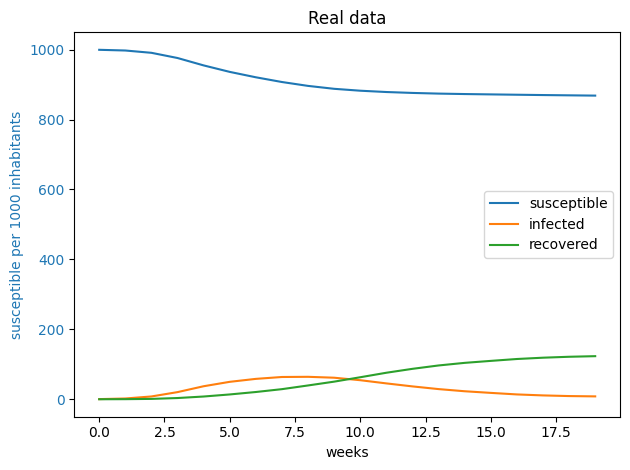

In [2]:
real_data = np.loadtxt("data/italy_20_weeks.txt")
sir_util.plotSeries("Real data", real_data)

### Initialize a calibrator object

#### 1. Model simulator

In [3]:
from models.sir.sir_docker import SIR_w_breaks

#### 2. Loss function

We'll use a quadratic loss, a simple squared difference bewteen the two series

In [4]:
loss = MinkowskiLoss()

#### 3. Samplers

Let's choose an advanced, static combination of samplers. In the next demo we will follow a different approach.

In [5]:
sampler_batch_size = 16
samplers = [
    HaltonSampler(batch_size=sampler_batch_size),
    RandomForestSampler(batch_size=sampler_batch_size),
    BestBatchSampler(batch_size=sampler_batch_size),
]

#### 4. Parameter space (bounds and precision)

In [6]:
#    brktime, beta1, beta2, gamma
bounds_w_breaks = [
    [2, 0.1, 0,   0.1],
    [7, 0.2, 0.1, 0.3],
]
precisions_w_breaks = [1, 0.0005, 0.0005, 0.0005]

#### Initialize the Calibrator

There are almost **100 million** possible parameters to explore:

In [7]:
saving_folder = "output"
cal = Calibrator(
    samplers=samplers,
    real_data=real_data,
    model=SIR_w_breaks,
    parameters_bounds=bounds_w_breaks,
    parameters_precision=precisions_w_breaks,
    ensemble_size=1,
    loss_function=loss,
    saving_folder=saving_folder,
    random_state=0,
)


***
Number of free params:       4.
Explorable param space size: 97204806.
***

Selecting 32 processes for the parallel evaluation of the model


### Calibration

Perform 15 calibration rounds.

Note that, with these parameters, we would be able to achieve a much lower loss in 30 epochs.

In [8]:
params, losses = cal.calibrate(15)


BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: HaltonSampler
----> sim exec elapsed time: 0.4s
---->   min loss new params: 63.65
---->   avg loss new params: 119.92
----> avg loss exist params: 119.92
---->         curr min loss: 63.64584657370736
====>    total elapsed time: 0.4s

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 60.15
---->   avg loss new params: 89.74
----> avg loss exist params: 104.83
---->         curr min loss: 60.14995851621238
====>    total elapsed time: 0.8s

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 52.45
---->   avg loss new params: 86.08
----> avg loss exist params: 98.58
---->         curr min loss: 52.451259058399316
====>    total elapsed time: 0.0s
Checkpoint saved in 0.0s

BATCH NUMBER:   2
PARAMS SAMPLED: 48

METHOD: HaltonSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 57.1
---->   avg loss new params: 114.49
----> avg loss exist params: 10

----> sim exec elapsed time: 0.0s
---->   min loss new params: 37.04
---->   avg loss new params: 48.33
----> avg loss exist params: 87.15
---->         curr min loss: 35.795816477172046
====>    total elapsed time: 0.9s

METHOD: BestBatchSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 41.35
---->   avg loss new params: 75.57
----> avg loss exist params: 86.8
---->         curr min loss: 35.795816477172046
====>    total elapsed time: 0.0s
Checkpoint saved in 0.0s

BATCH NUMBER:   12
PARAMS SAMPLED: 528

METHOD: HaltonSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 68.68
---->   avg loss new params: 118.55
----> avg loss exist params: 87.73
---->         curr min loss: 35.795816477172046
====>    total elapsed time: 0.0s

METHOD: RandomForestSampler
----> sim exec elapsed time: 0.0s
---->   min loss new params: 38.2
---->   avg loss new params: 47.02
----> avg loss exist params: 86.57
---->         curr min loss: 35.795816477172046
====>   

Best parameters obtained so far:

In [9]:
sir_util.printBestParams(params)

                  brktime  beta1    beta2    gamma
Best parameters: [7.000    0.176    0.038    0.205   ]


### Compare the original and the calibrated time series

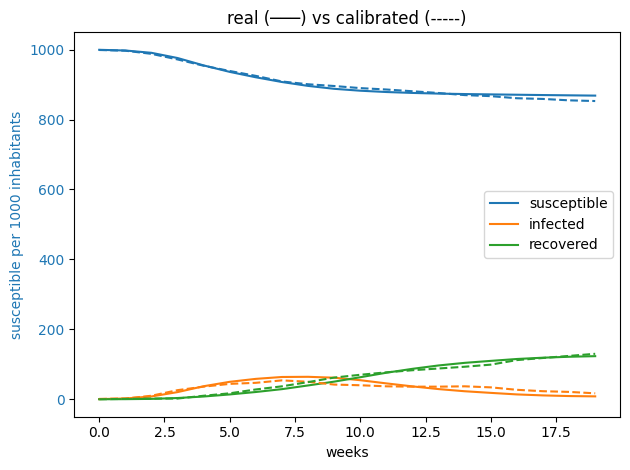

In [10]:
idxmin = np.argmin(cal.losses_samp)
sir_util.plotSeries("real (───) vs calibrated (-----)", real_data, cal.series_samp[idxmin, 0])

## Plots

Let's use the **black-it built-in functions** to visually explore how the calibration progressed.

In [11]:
plot_sampling_interact(saving_folder)

interactive(children=(Dropdown(description='batch_nums', options={'from 0 to 4': [0, 1, 2, 3, 4], 'from 5 to 9…

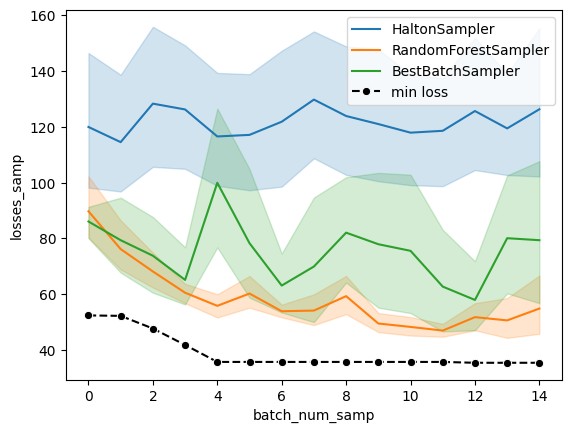

In [12]:
plot_convergence(saving_folder)